In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!yes | add-apt-repository ppa:mscore-ubuntu/mscore3-stable &>/dev/null
!apt update &>/dev/null
!apt install musescore3 &>/dev/null
print("MuseScore installation finished")
!pip uninstall music21 -y &>/dev/null
!pip install music21 &>/dev/null
!pip install mido &>/dev/null
!pip install muspy &>/dev/null
!pip install pypianoroll &>/dev/null

MuseScore installation finished


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/mmm-project/museGANV3

/content/drive/MyDrive/Colab Notebooks/mmm-project/museGANV3


In [4]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import mido
import pypianoroll
import string
from music21 import *
from models.MuseGAN import MuseGAN
from utils.loaders import load_music
from tensorflow.keras.models import load_model

In [5]:
import random
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

seed_everything(3037)

In [6]:
print(repr(string))

<module 'string' from '/usr/lib/python3.7/string.py'>


In [7]:
#us = environment.UserSettings()
#us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
#us['directoryScratch'] = '/tmp'
os.putenv("QT_QPA_PLATFORM", "offscreen")
os.putenv("XDG_RUNTIME_DIR", environment.Environment().getRootTempDir())

In [8]:
# run params
SECTION = 'compose'
RUN_ID = '10'
DATA_BASE = 'dataset'
DATA_NAME = 'chorales'
FILENAME = 'Jsb16thSeparated.npz'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

In [9]:
os.listdir(RUN_FOLDER + '/weights')

['weights-g-30.h5',
 'weights-g-20.h5',
 'weights-g-10.h5',
 'weights-g-0.h5',
 'weights-g-80.h5',
 'weights-g-70.h5',
 'weights-g-60.h5',
 'weights-g-50.h5',
 'weights-g-40.h5',
 'weights-g-120.h5',
 'weights-g-110.h5',
 'weights-g-100.h5',
 'weights-g-90.h5',
 'weights-g-170.h5',
 'weights-g-160.h5',
 'weights-g-150.h5',
 'weights-g-140.h5',
 'weights-g-130.h5',
 'weights-g-210.h5',
 'weights-g-200.h5',
 'weights-g-190.h5',
 'weights-g-180.h5',
 'weights-g-260.h5',
 'weights-g-250.h5',
 'weights-g-240.h5',
 'weights-g-230.h5',
 'weights-g-220.h5',
 'weights-g-310.h5',
 'weights-g-300.h5',
 'weights-g-290.h5',
 'weights-g-280.h5',
 'weights-g-270.h5',
 'weights-g-360.h5',
 'weights-g-350.h5',
 'weights-g-340.h5',
 'weights-g-330.h5',
 'weights-g-320.h5',
 'weights-g-410.h5',
 'weights-g-400.h5',
 'weights-g-390.h5',
 'weights-g-380.h5',
 'weights-g-370.h5',
 'weights-g-450.h5',
 'weights-g-440.h5',
 'weights-g-430.h5',
 'weights-g-420.h5',
 'weights-g-500.h5',
 'weights-g-490.h5',
 'w

## data

In [10]:
BATCH_SIZE = 64
n_bars = 2
n_steps_per_bar = 16
n_pitches = 84
n_tracks = 4

data_binary, data_ints, raw_data = load_music( DATA_BASE +'/'+ DATA_NAME, FILENAME, n_bars, n_steps_per_bar)
print(data_binary.shape)
print(data_ints.shape)
# data_binary = np.squeeze(data_binary)

(229, 2, 16, 84, 4)
(229, 2, 16, 4)


In [11]:
gan = MuseGAN(input_dim = data_binary.shape[1:]
        , critic_learning_rate = 0.001
        , generator_learning_rate = 0.001
        , optimiser = 'adam'
        , grad_weight = 10
        , z_dim = 32
        , batch_size = BATCH_SIZE
        , n_tracks = n_tracks
        , n_bars = n_bars
        , n_steps_per_bar = n_steps_per_bar
        , n_pitches = n_pitches
        )

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        result[note-21] = velocity if on_ else 0
    return result
    
def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]

def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]

def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result


def mid2arry(midi_file_str, min_msg_pct=0.1):
    mid = mido.MidiFile(midi_file_str, clip=True)
    mid.tracks

    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    return all_arys[min(ends): max(ends)]

In [13]:
gan.load_weights(RUN_FOLDER, 2400)

In [14]:
gan.generator.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 melody_input (InputLayer)      [(None, 4, 32)]      0           []                               
                                                                                                  
 chords_input (InputLayer)      [(None, 32)]         0           []                               
                                                                                                  
 lambda (Lambda)                (None, 32)           0           ['melody_input[0][0]']           
                                                                                                  
 lambda_1 (Lambda)              (None, 32)           0           ['melody_input[0][0]']           
                                                                                           

# view sample score

In [ ]:
data_binary[-1:, :, :, :, -1:].shape

In [ ]:
len(data_binary[data_binary!=-1])

In [ ]:
np.unique(data_binary)

In [15]:
chords_noise = np.random.normal(0, 1, (1, gan.z_dim))
style_noise = np.random.normal(0, 1, (1, gan.z_dim))
melody_noise = np.random.normal(0, 1, (1, gan.n_tracks, gan.z_dim))
groove_noise = np.random.normal(0, 1, (1, gan.n_tracks, gan.z_dim))

In [16]:
cond_input_temp = mid2arry("./input_midis/shark.mid") # np.random.choice([-1., 1.], (1, gan.n_bars, gan.n_steps_per_bar, gan.n_pitches, 1)) # (1, 2, 16, 84, 1)

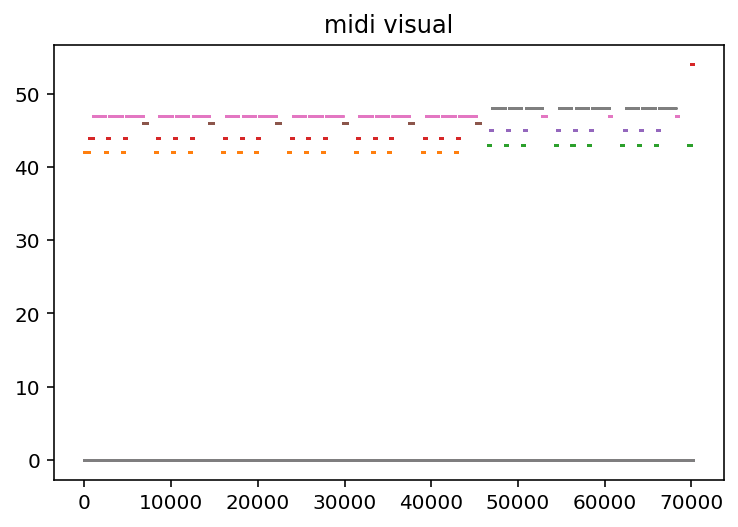

In [17]:
result_array = cond_input_temp
plt.plot(range(result_array.shape[0]), np.multiply(np.where(result_array>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
plt.title("midi visual")
plt.show()

In [18]:
cond_input_temp.shape

(70197, 88)

In [19]:
beat_resolution = 4
phrase_length = 32

midi_file = "./input_midis/shark.mid"

parsed = pypianoroll.read(midi_file)
pypianoroll.set_resolution(parsed, resolution=beat_resolution)

sample_c = parsed.tracks[0].pianoroll.astype(np.float32)

# 처음 무음 제거
first_non_zero = np.nonzero(sample_c.sum(axis=1))[0][0]

# 길이만큼 마디수 사용
sample_c = sample_c[first_non_zero: first_non_zero + phrase_length]

# Binarize data (ignore velocity value)
sample_c[sample_c > 0] = 1
sample_c[sample_c <= 0] = -1

sample_c = np.expand_dims(np.expand_dims(sample_c, 0), -1)  # 1, 32, 128, 1
sample_c_1, sample_c_2 = np.split(sample_c, 2, axis=1)
sample_c = np.stack([sample_c_1, sample_c_2], axis=1)

sample_c = sample_c[:, :, :, 24:24+84, :]

print(sample_c.shape) # (1, 2, 16, 84, 1)
# sample_c = tf.convert_to_tensor(sample_c, dtype=tf.float32)

(1, 2, 16, 84, 1)


In [20]:
gen_scores = gan.generator.predict([sample_c, chords_noise, style_noise, melody_noise, groove_noise])

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [21]:
np.argmax(gen_scores[0,0,0:4,:,3], axis = 1)

array([38, 38, 38, 38])

In [ ]:
gen_scores[0,0,0:4,60,3] = 0.02347812

In [22]:
gen_scores.shape

(1, 2, 16, 84, 4)

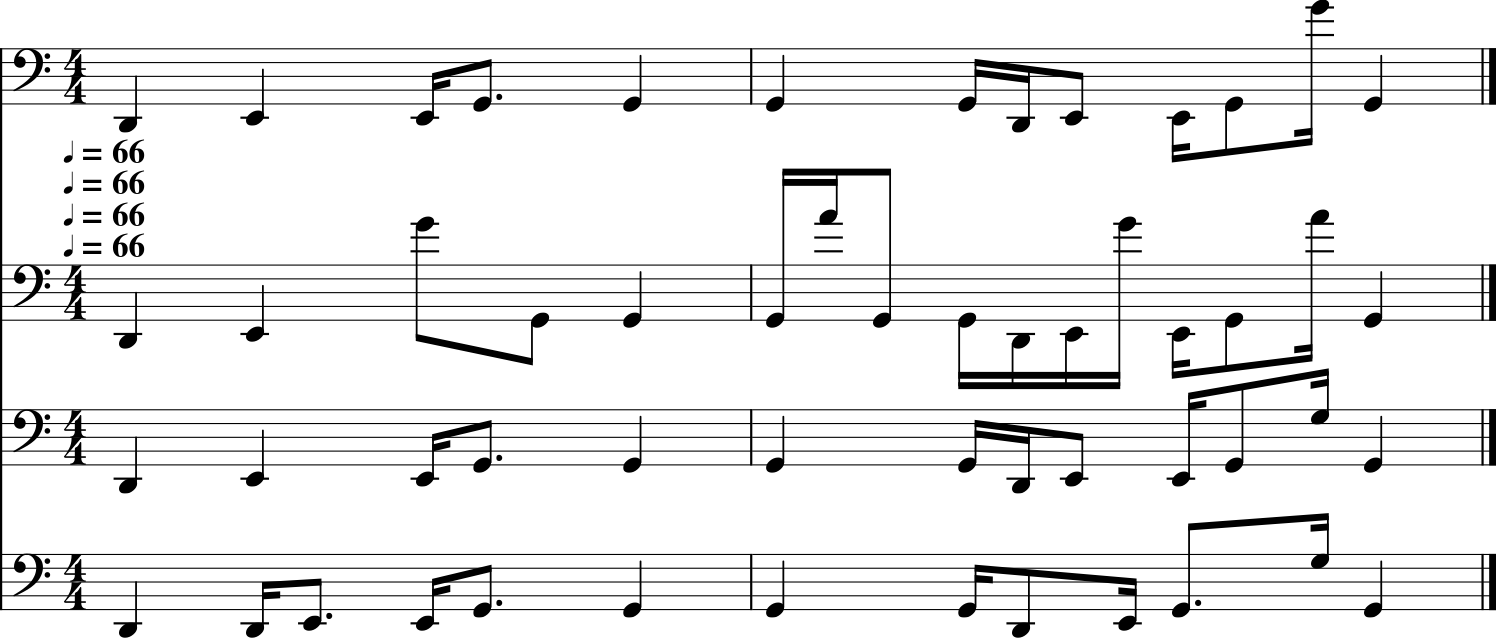

In [23]:
filename = 'example'
gan.notes_to_midi(RUN_FOLDER, gen_scores, filename)
gen_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
gen_score.show()

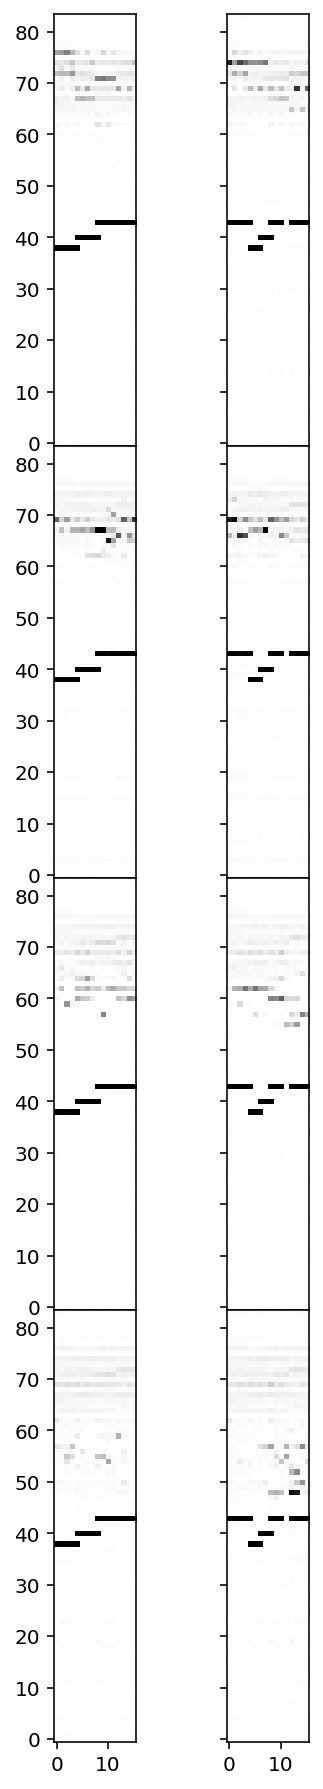

In [24]:
gan.draw_score(gen_scores, 0)

# find the closest match

In [25]:
def find_closest(data_binary, score):
    current_dist = 99999999
    current_i = -1
    for i, d in enumerate(data_binary):
        dist = np.sqrt(np.sum(pow((d - score),2)))
        if dist < current_dist:
            current_i = i
            current_dist = dist
        
    return current_i
    

In [26]:
closest_idx = find_closest(data_binary, gen_scores[0])
closest_data = data_binary[[closest_idx]]
print(closest_idx)

34


original


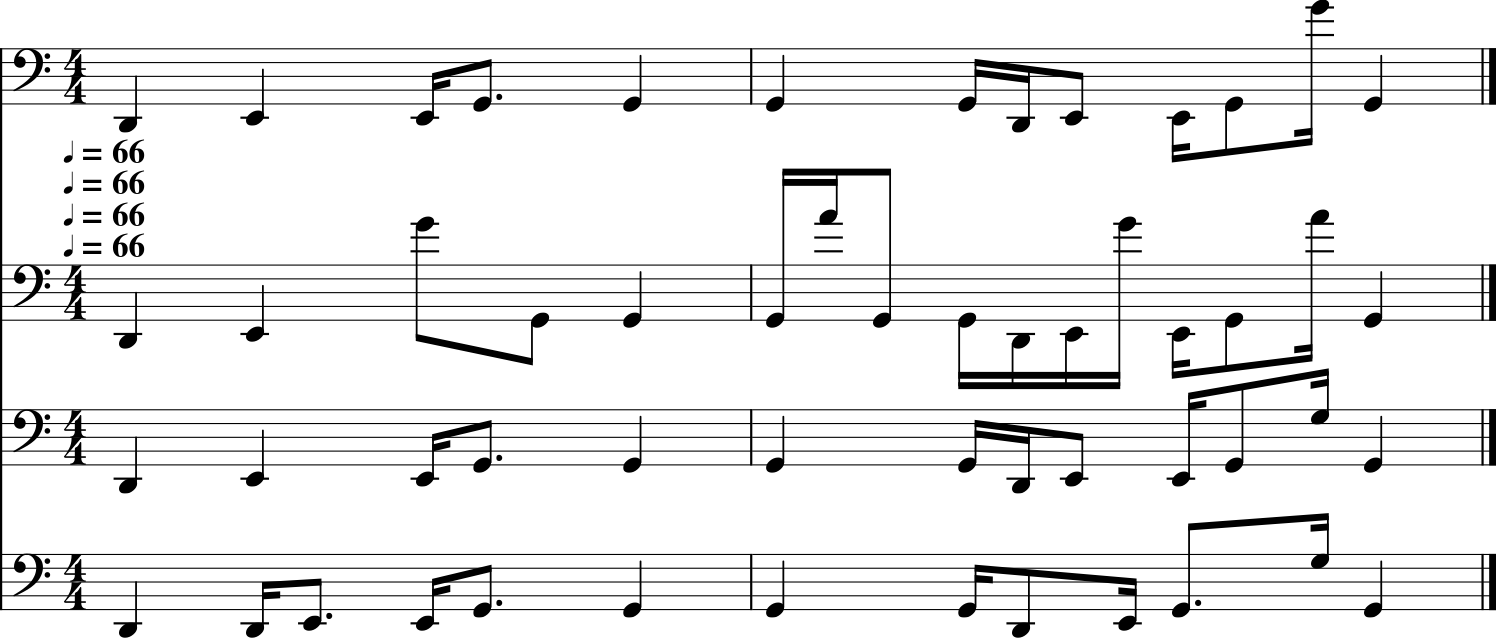

closest


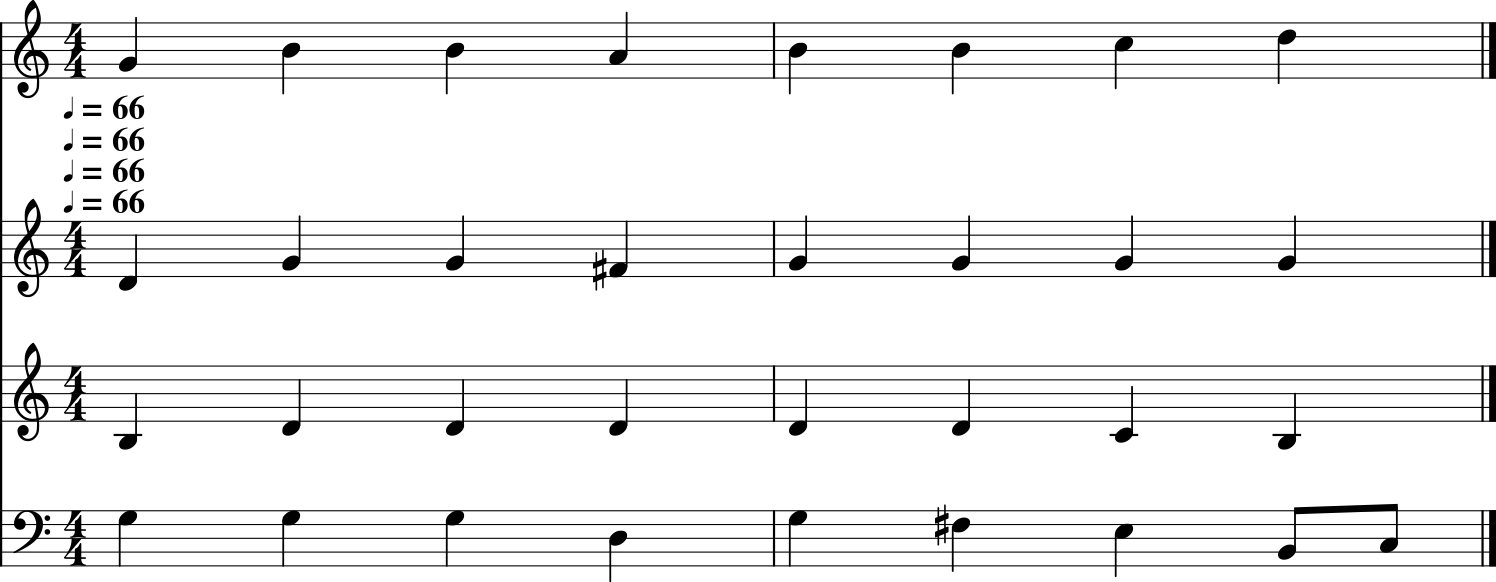

In [27]:
filename = 'closest'
gan.notes_to_midi(RUN_FOLDER, closest_data,filename)
closest_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('closest')
closest_score.show()


# changing the chords noise

In [28]:
chords_noise_2 = 5 * np.ones((1, gan.z_dim))

In [29]:
chords_scores = gan.generator.predict([sample_c, chords_noise_2, style_noise, melody_noise, groove_noise])

original


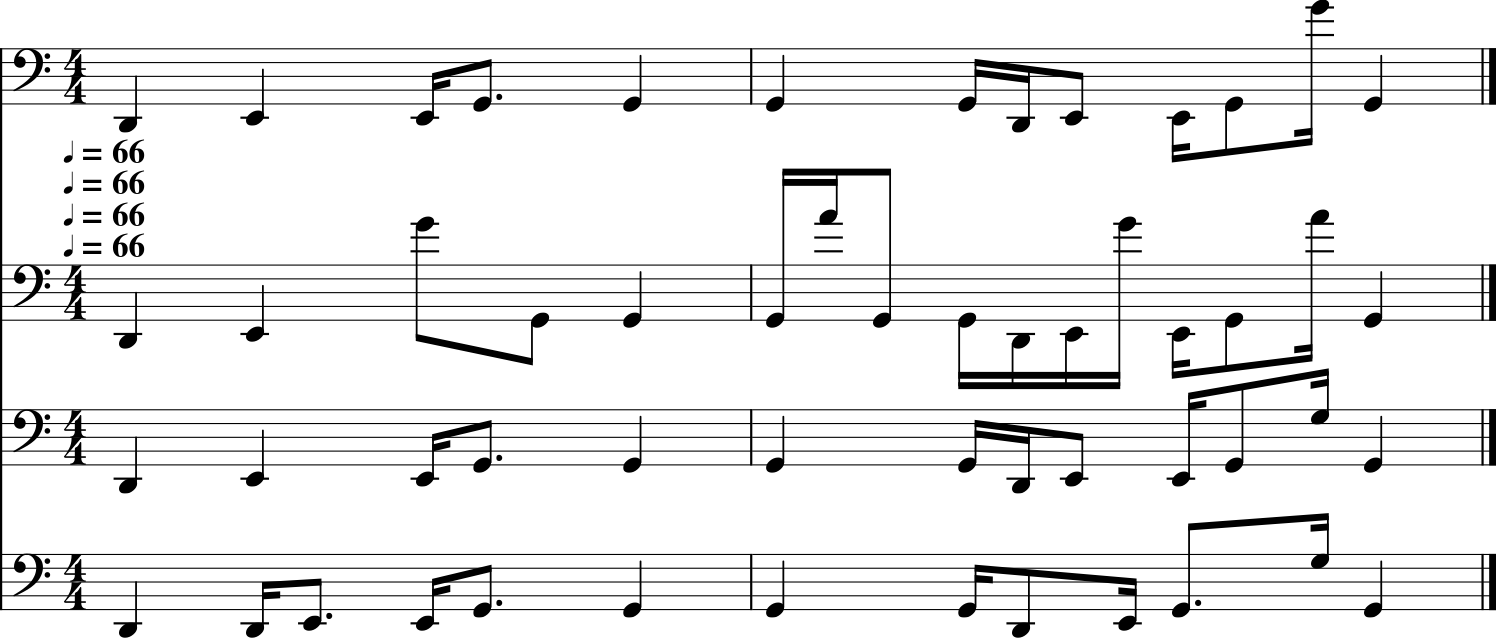

chords noise changed


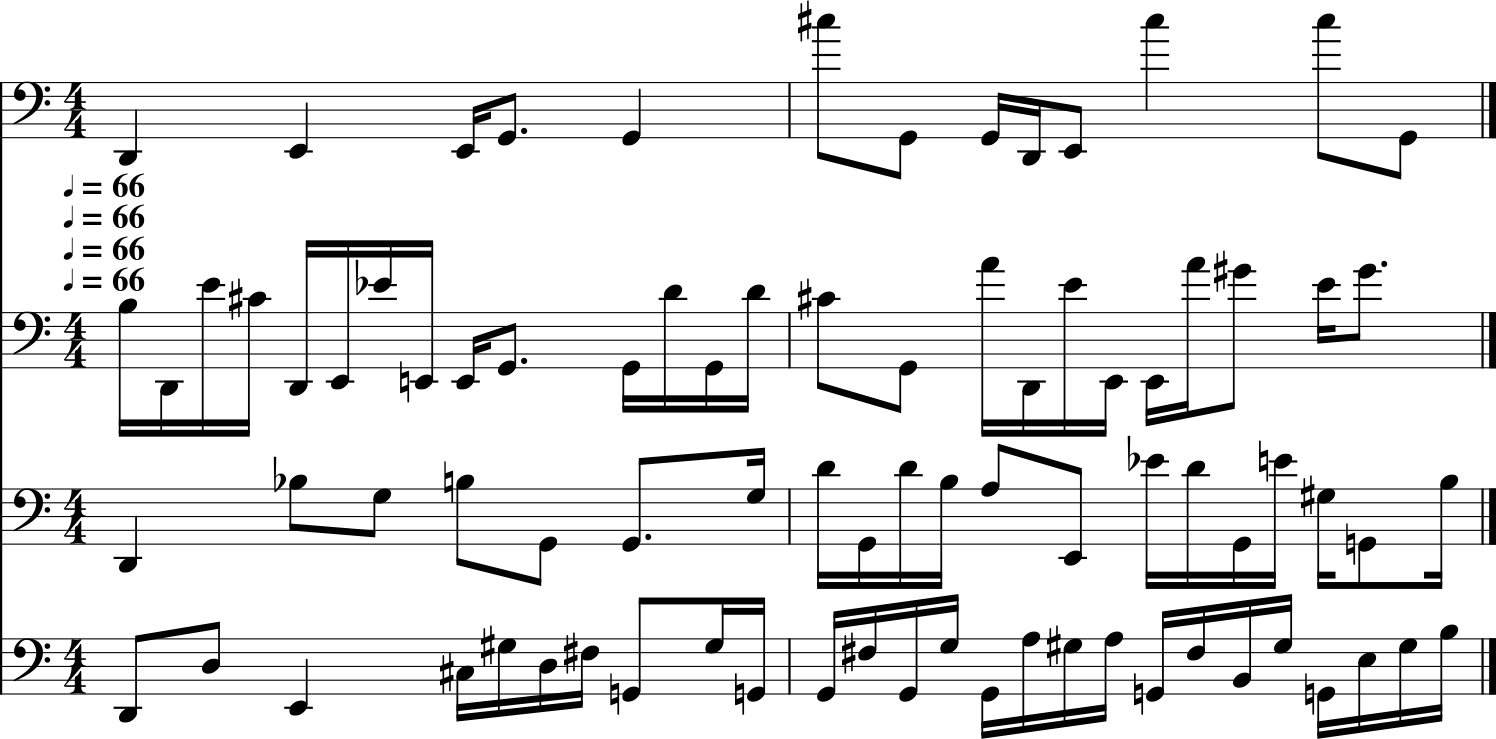

In [30]:
filename = 'changing_chords'
gan.notes_to_midi(RUN_FOLDER, chords_scores, filename)
chords_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('chords noise changed')
chords_score.show()

# changing the style noise

In [31]:
style_noise_2 = 5 * np.ones((1, gan.z_dim))

In [32]:
style_scores = gan.generator.predict([sample_c, chords_noise, style_noise_2, melody_noise, groove_noise])

original


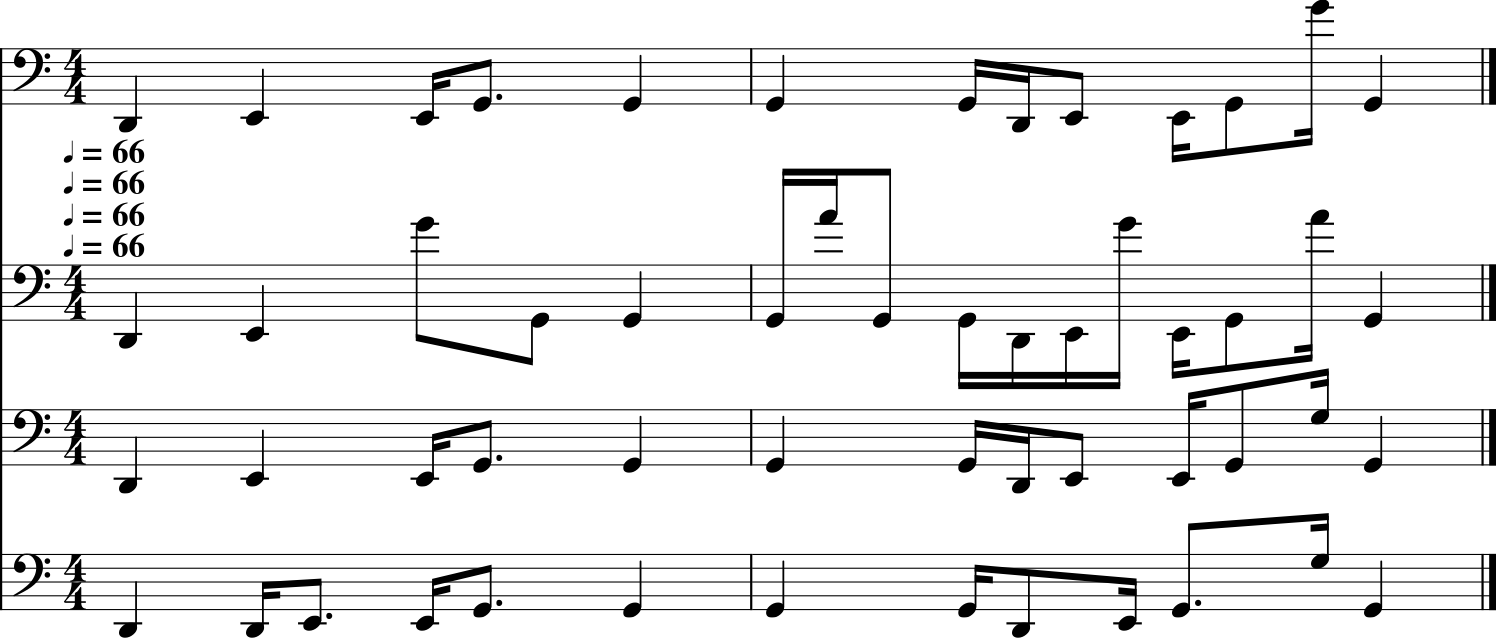

style noise changed


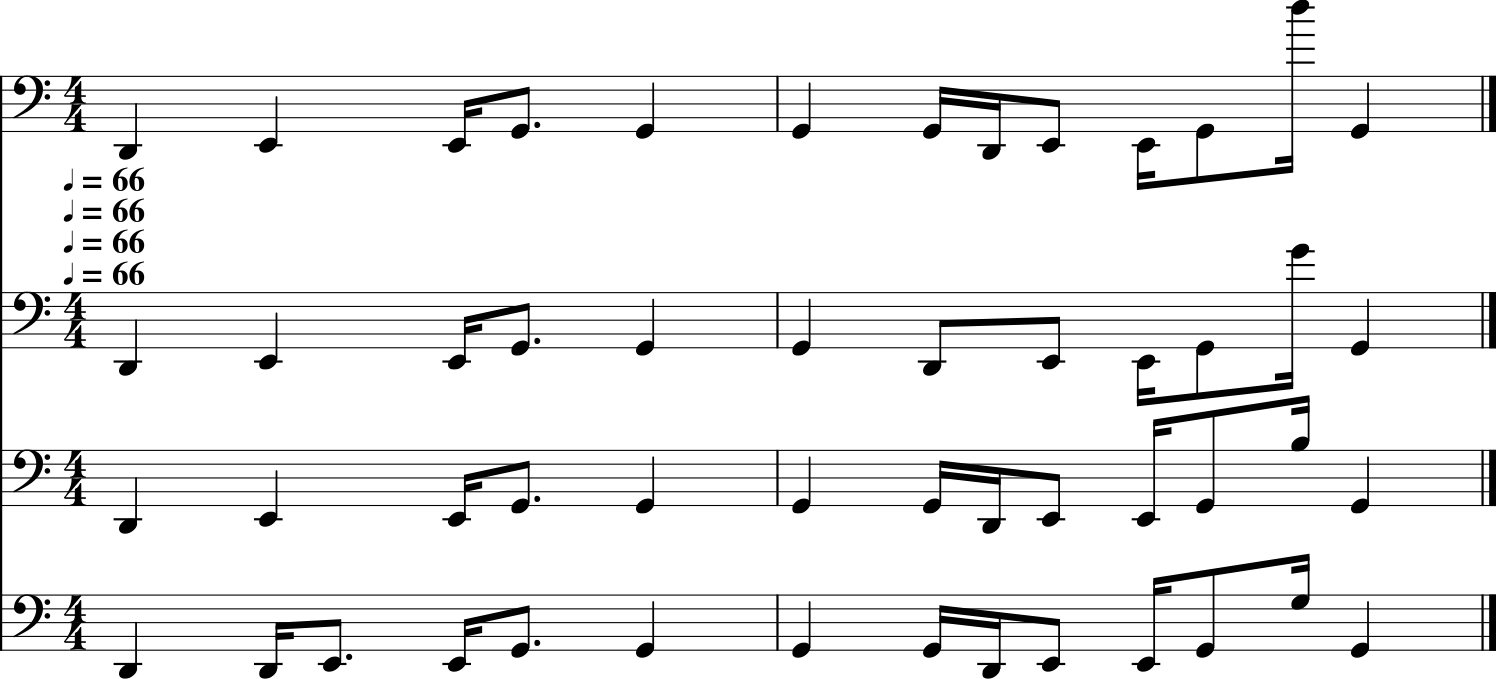

In [33]:
filename = 'changing_style'
gan.notes_to_midi(RUN_FOLDER, style_scores, filename)
style_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('style noise changed')
style_score.show()

# changing the melody noise

In [34]:
melody_noise_2 = np.copy(melody_noise)
melody_noise_2[0,0,:] = 5 * np.ones(gan.z_dim)

In [35]:
melody_scores = gan.generator.predict([sample_c, chords_noise, style_noise, melody_noise_2, groove_noise])

original


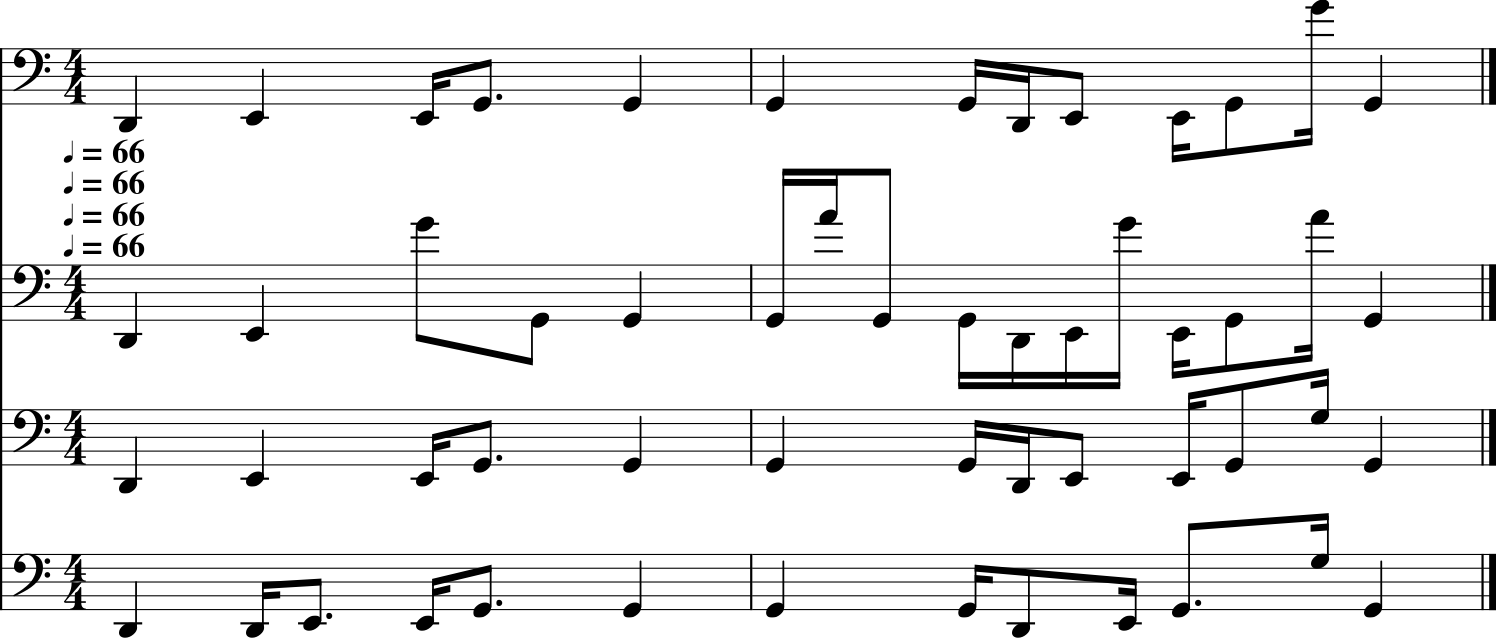

melody noise changed


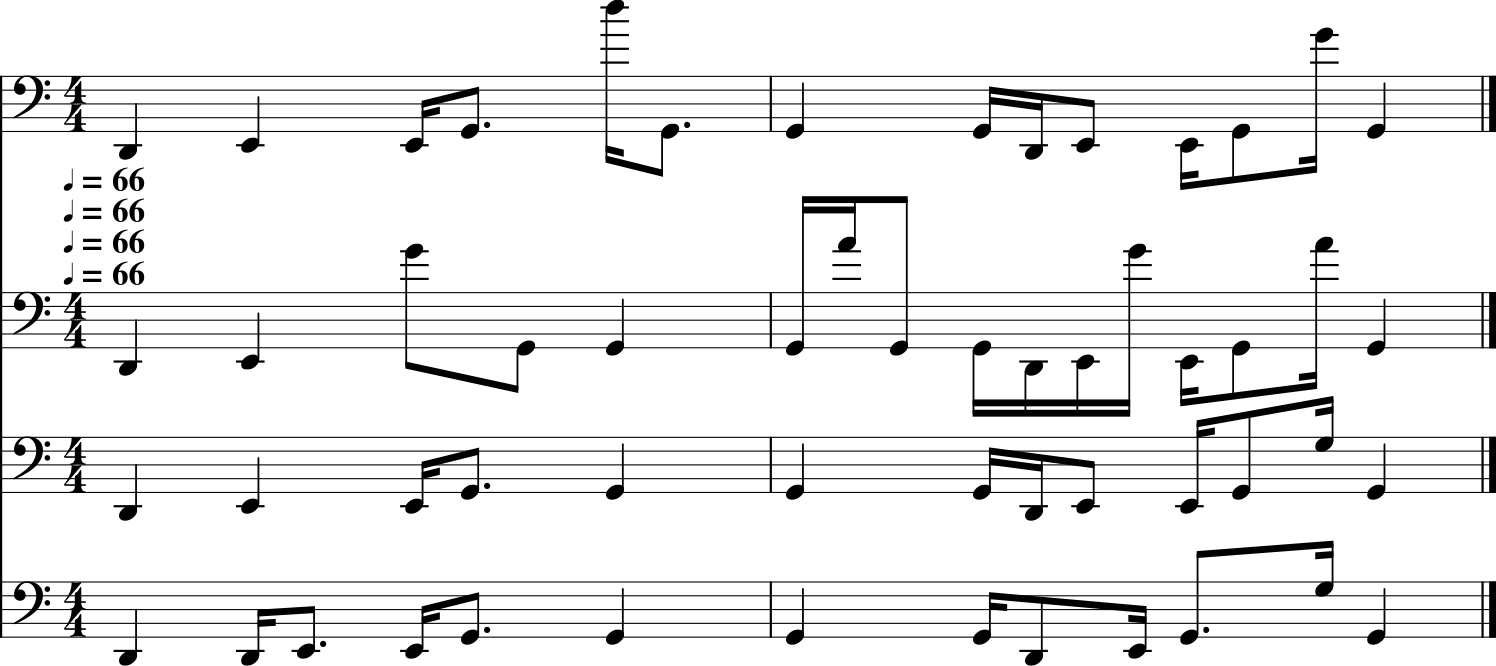

In [36]:
filename = 'changing_melody'
gan.notes_to_midi(RUN_FOLDER, melody_scores, filename)
melody_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('melody noise changed')
melody_score.show()

# changing the groove noise

In [37]:
groove_noise_2 = np.copy(groove_noise)
groove_noise_2[0,3,:] = 5 * np.ones(gan.z_dim)

In [38]:
groove_scores = gan.generator.predict([sample_c, chords_noise, style_noise, melody_noise, groove_noise_2])

original


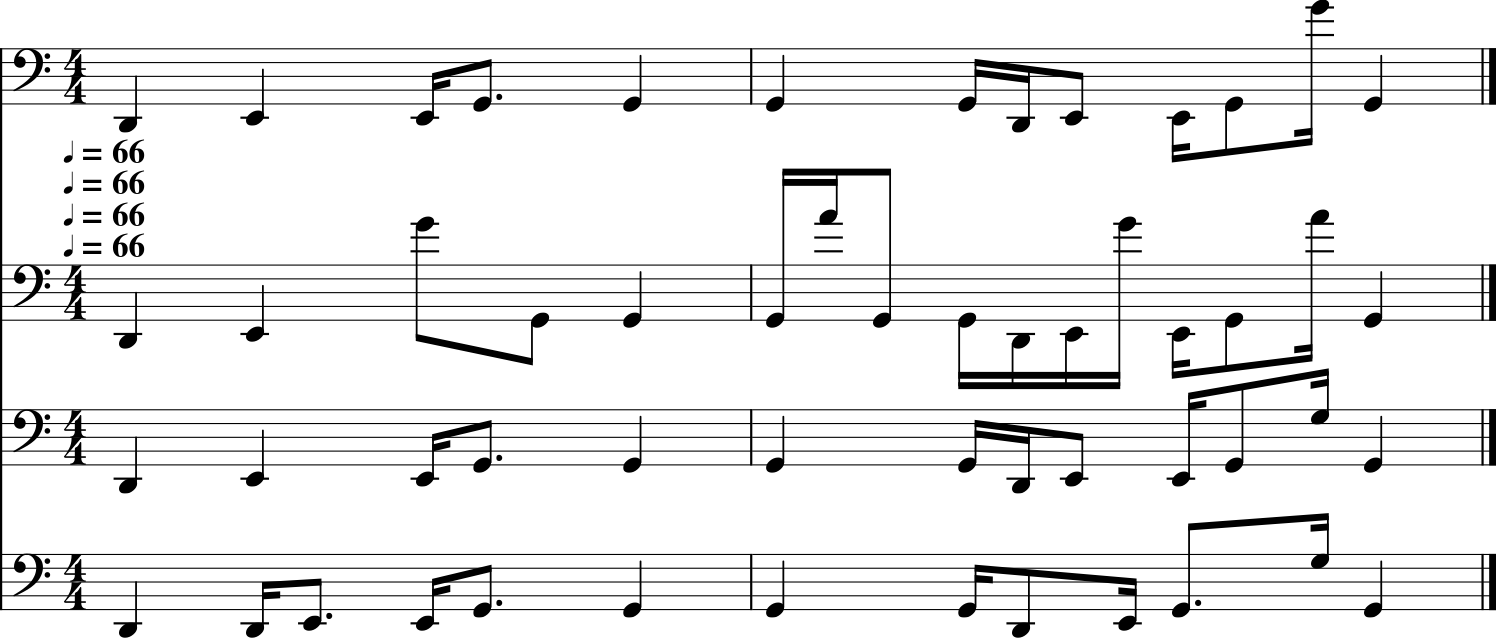

groove noise changed


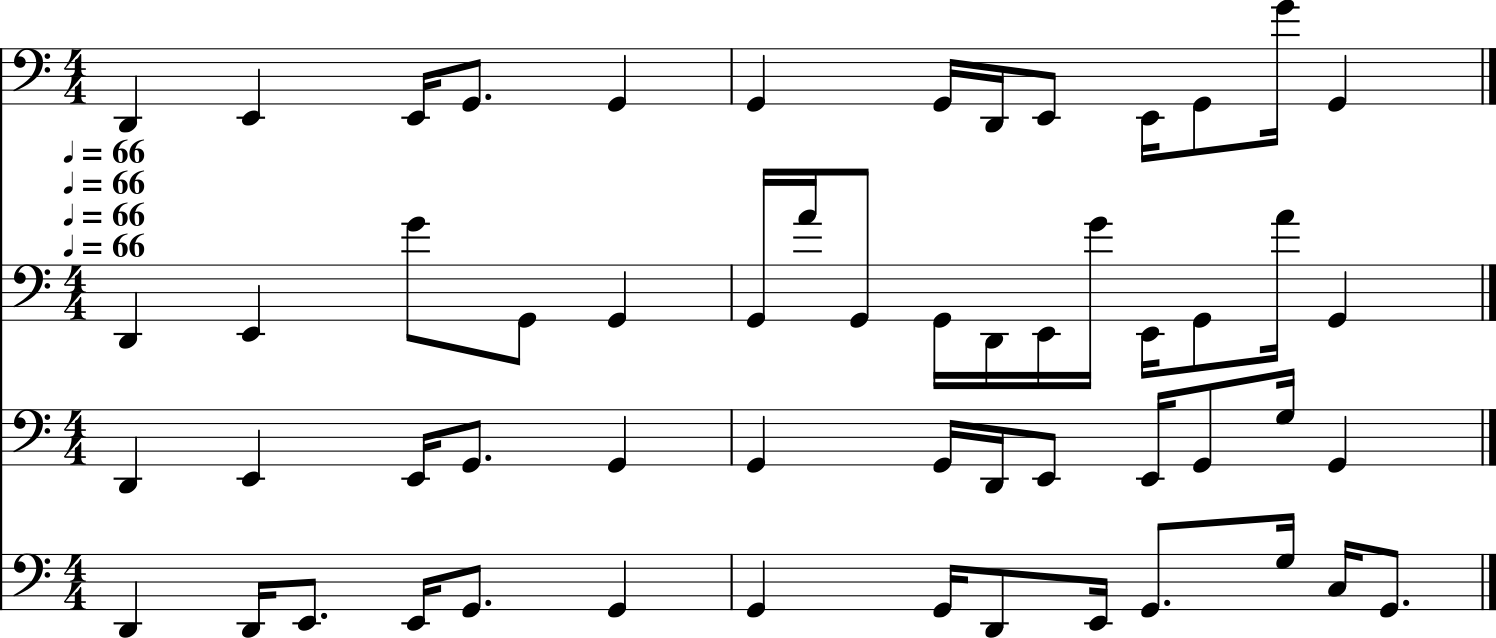

In [39]:
filename = 'changing_groove'
gan.notes_to_midi(RUN_FOLDER, groove_scores, filename)
groove_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('groove noise changed')
groove_score.show()